<a href="https://colab.research.google.com/github/ZsofiaK/masterthesis/blob/main/Implementation/Benchmarking/AK_sample_benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AK sample benchmarking

Benchmarking MARINE on a representative sample of Animal Kingdom.

## Setting up requirements

In [1]:
# Setting up dictionaries for later ease of use.
dataset_dict = {'AK-sample' : 'AK sample'}

input_sizes_dict = {'dinov2-vits14-clf' : 384, 'dinov2-vitg14-clf' : 1536,
                    'dinov2-vits14-reg-clf' : 384, 'dinov2-vitg14-reg-clf' : 1536}

In [2]:
# Set the dataset, model and embedding specifics for the classification.

dataset_name = 'AK-sample'

dataset_dir = dataset_dict[dataset_name]

nr_classes = 140    # Number of classes in the AK dataset.

image_size = 448    # The size of the embedded images.

frame_selection_method = 'evenly_10'

embedding_method = 'dinov2-vitg14-clf'

clf_name = 'ShallowNetwork'

seed = 23   # For reproducability in pseudo-randomness.

nr_frames = int(frame_selection_method.split('_')[-1])

input_size = input_sizes_dict[embedding_method] * nr_frames   # Size of the input vectors (embeddings).

In [3]:
# Setting up parameters for cross validation.

# Number of folds to use.
cv_folds = 3

# Parameter grids to use for the models.
param_grid = { 'ShallowNetwork': {
    'layers': [0, 1, 2, 3],
    'dropout_rate': [0.0, 0.25, 0.5],
    'learning_rate': [0.01, 0.001, 0.0001]
}
}

In [4]:
# Setting up folder to save outputs.
import os

output_dir = 'Output'
os.makedirs(output_dir, exist_ok=True)

In [5]:
# Mount Drive.
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Specify data source
data_dir = f"/content/drive/MyDrive/UvA/M Thesis/Data/{dataset_dir}"

## Loading data

In [7]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from IPython.display import clear_output
import shutil

In [8]:
# Specify embedding locations
embeddings_dir = f'{data_dir}/Embeddings/{embedding_method}/{image_size}'
local_embeddings_dir = f'/content/{dataset_dir}/Embeddings/{embedding_method}/{image_size}'

os.makedirs(local_embeddings_dir, exist_ok=True)

In [9]:
# Copy embeddings to runtime.
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

video_dirs = os.listdir(embeddings_dir)
nr_videos = len(video_dirs)

# Function to copy a single video directory
def copy_video_dir(video_dir):
    video_dir_path = os.path.join(embeddings_dir, video_dir)
    local_video_dir_path = os.path.join(local_embeddings_dir, video_dir)

    shutil.copytree(video_dir_path, local_video_dir_path)

    return video_dir

if len(os.listdir(local_embeddings_dir)) < nr_videos:    # Only copy if not already done.
  # Progress tracker
  progress = 0

  # Copy directories in parallel
  with ThreadPoolExecutor(max_workers=8) as executor:
      futures = [executor.submit(copy_video_dir, video_dir) for video_dir in video_dirs]

      for future in futures:
        future.result()  # Wait for each future to complete

        progress += 1

        clear_output(wait=True)
        print(f'Progress: {progress / nr_videos * 100:.2f}%')

else:
  print('Embeddings have already been copied.')

Embeddings have already been copied.


In [10]:
# Specify metadata tables.
clips_csv_path = f'{data_dir}/clips.csv'
frame_selection_path = f'{data_dir}/Selected frames/{dataset_name}_{frame_selection_method}.csv'

clips_df = pd.read_csv(clips_csv_path)
frames_df = pd.read_csv(frame_selection_path, index_col='video')

In [11]:
# Load video embeddings and labels
nr_clips = len(clips_df)
progress = 0

X_train = []  # Embeddings
X_test = []
y_train = []  # Labels
y_test = []

video_names_train = []  # Video names for saving predictions
video_names_test = []

not_found_embeddings = []

for index, row in clips_df.iterrows():
  skip_to_next = False

  video_name = row['video'].replace('.mp4', '')
  labels = [int(label) for label in eval(row['labels'])]    # Reading label numbers.

  embedding_path = f'{local_embeddings_dir}/{video_name}'

  if video_name in video_names_train or video_name in video_names_test:
    continue      # Skip embeddings which have already been read.

  if not os.path.exists(embedding_path):
    not_found_embeddings.append((video_name, 'all'))

    progress += 1

    clear_output(wait=True)
    print(f'Number of videos: {nr_clips}')
    print(f'Progress: {progress/nr_clips * 100:.2f}%')

    continue

  frames = eval(frames_df['frames'][f'{video_name}.mp4'])

  embedding = []

  for frame_idx in frames:
    frame_embedding_path = f'{embedding_path}/{video_name}_{frame_idx}.npy'

    if not os.path.exists(frame_embedding_path):
      not_found_embeddings.append((video_name, frame_idx))

      skip_to_next = True   # Skip to next video

      break

    try:
      frame_embedding = np.load(frame_embedding_path)

    except:
      print(video_name, 'Unable to load an embedding.')
      break

    embedding.append(frame_embedding)

  if skip_to_next:
    progress += 1

    clear_output(wait=True)
    print(f'Number of videos: {nr_clips}')
    print(f'Progress: {progress/nr_clips * 100:.2f}%')

    continue

  # Concatenate frame embeddings into numpy feature array.
  np_embedding = np.concatenate(embedding)

  # Create labels array: length of the number of classes, with 1s in the positions
  # which classes apply and 0s elsewhere.
  labels_array = np.zeros(nr_classes, dtype=int)

  positive_positions = [label - 1 for label in labels]    # Positions in which the labels array must contain a 1 (due to 0 indexing).

  labels_array[positive_positions] = 1    # Setting the positive classes in the labels array.

  # Append instance to the appropriate split.
  if row['type'] == 'train':
    X_train.append(np_embedding)
    y_train.append(labels_array)
    video_names_train.append(video_name)

  elif row['type'] == 'test':
    X_test.append(np_embedding)
    y_test.append(labels_array)
    video_names_test.append(video_name)

  progress += 1

  clear_output(wait=True)
  print(f'Number of videos: {nr_clips}')
  print(f'Progress: {progress/nr_clips * 100:.2f}%')

Number of videos: 1000
Progress: 100.00%


In [12]:
# Check if all embeddings were successfully loaded.
if len(not_found_embeddings) > 0:
  print(f' WARNING: Failed to find embeddings for {len(set(([item[0] for item in not_found_embeddings])))} videos.')

else:
  print('Success! All embeddings read.')

Success! All embeddings read.


In [13]:
# Check if all embeddings have the required input size and pad the ones which do not.
X_train_original = X_train.copy()
X_test_original = X_test.copy()
y_train_original = y_train.copy()
y_test_original = y_test.copy()
video_names_train_original = video_names_train.copy()
video_names_test_original = video_names_test.copy()

X_train = []
X_test = []
y_train = []
y_test = []
video_names_train = []
video_names_test = []

padded_train = 0
padded_test = 0

for i, array in enumerate(X_train_original):
  if len(array) == input_size:
    X_train.append(array)

  elif len(array) < input_size:
    difference = input_size - len(array)

    padding_size_beginning = difference // 2 + ((difference % 2) * 1)
    padding_size_end = difference // 2

    padded_array = np.pad(array, (padding_size_beginning, padding_size_end), \
                          mode='constant', constant_values=(0, 0))

    X_train.append(padded_array)

    padded_train += 1

  y_train.append(y_train_original[i])
  video_names_train.append(video_names_train_original[i])

for i, array in enumerate(X_test_original):
  if len(array) == input_size:
    X_test.append(array)

  elif len(array) < input_size:
    difference = input_size - len(array)

    padding_size_beginning = difference // 2 + ((difference % 2) * 1)
    padding_size_end = difference // 2

    padded_array = np.pad(array, (padding_size_beginning, padding_size_end), \
                           mode='constant', constant_values=(0, 0))

    X_test.append(padded_array)

    padded_test += 1

  y_test.append(y_test_original[i])
  video_names_test.append(video_names_test_original[i])

In [14]:
# Check if any embeddings had to be removed.
print(f'{padded_train} embeddings were padded in training set due to incorrect embedding size.')
print(f'{padded_test} embeddings were padded in test set due to incorrect embedding size.')

0 embeddings were padded in training set due to incorrect embedding size.
0 embeddings were padded in test set due to incorrect embedding size.


In [15]:
# Converting to numpy.
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [16]:
# Remove classes which are not represented in the sample.

# Identify label columns in the target arrays which only contain 0s.
all_labels = np.concatenate((y_train, y_test), axis=0)

zero_label_columns = np.all(all_labels == 0, axis=0)

# Save these labels as a list.
zero_labels = np.where(zero_label_columns)[0].tolist()

zero_labels = sorted([label + 1 for label in zero_labels])    # Adjust for 0 indexing and sort.

# Remove these columns from the target arrays.
y_train = y_train[:, ~zero_label_columns]
y_test = y_test[:, ~zero_label_columns]

actual_nr_classes = y_train.shape[1]
print(f'Actual number of classes: {actual_nr_classes}')
print()

print(f'New shape of target arrays:')
print(f'Train: {y_train.shape}')
print(f'Test: {y_test.shape}')

Actual number of classes: 93

New shape of target arrays:
Train: (797, 93)
Test: (203, 93)


In [17]:
# Handle class imbalance through class weights (stored in a numpy array).
# For this, class weights will be defined as the inverse of their frequencies.

all_labels = np.concatenate((y_train, y_test), axis=0)

# Compute the frequency of each class
class_frequencies = np.sum(all_labels, axis=0)

# Compute the total number of samples
n_samples = all_labels.shape[0]

# Compute class weights as the inverse of class frequencies
# Use epsilon as a smoothing parameter to avoid problems with 0 division.
epsilon = 10e-6

class_weights = n_samples / (actual_nr_classes * (class_frequencies + epsilon))

# Create array of sample weights, which uses the maximum class weight of
# each sample as their weight.

# Initialize sample weights array as 1 for every sample.
sample_weights = np.ones((y_train.shape[0],))

for i in range(y_train.shape[0]):   # For each training instance
    # Collect class weights which apply to this instance.
    active_weights = [class_weights[j] for j in range(y_train.shape[1]) if y_train[i, j] == 1]

    if active_weights:  # Check if there are any classes which apply.
        sample_weights[i] = np.max(active_weights)

## Cross-validate model

In [18]:
## FUNCTIONS FOR MODEL CROSS-VALIDATION.

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import average_precision_score
from IPython.display import clear_output

# Function to calculate mAP (taken directly from Animal Kingdom).
def get_map(preds, labels):
  """
  Compute mAP for multi-label case.
  Args:
      preds (numpy tensor): num_examples x num_classes.
      labels (numpy tensor): num_examples x num_classes.
  Returns:
      mean_ap (int): final mAP score.
  https://github.com/facebookresearch/SlowFast/blob/2090f2918ac1ce890fdacd8fda2e590a46d5c734/slowfast/utils/meters.py#L231
  """
  preds = preds[:, ~(np.all(labels == 0, axis=0))]
  labels = labels[:, ~(np.all(labels == 0, axis=0))]
  aps = [0]
  try:
      aps = average_precision_score(labels, preds, average=None)
  except ValueError:
      print(
          "Average precision requires a sufficient number of samples \
          in a batch which are missing in this sample."
      )
  mean_ap = np.mean(aps)
  return mean_ap

def create_shallow_network(input_dim, hidden_layers, dropout_rate, learning_rate):
    model = Sequential()

    # Dense input layer with ReLu
    model.add(Dense(10, input_dim=input_dim, activation='relu'))

    # Dense hidden layers with ReLu and dropout
    for _ in range(hidden_layers):
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Dense output layer with sigmoid activation
    model.add(Dense(actual_nr_classes, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

def crossval_shallow_network(n_splits, input_dim, X, y, params_grid, \
                             verbose=False, random_state=seed):

  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

  # Set up best result tracker for grid search loop
  best_score = 0

  best_params = {}

  # Calculate number of runs for progress monitoring.
  total_runs = 1

  for params in params_grid.values():
    total_runs *= len(params)

  total_runs *= n_splits

  progress = 0

  # Grid search loop
  for hidden_layers in params_grid['layers']:
      for dropout_rate in params_grid['dropout_rate']:
          for learning_rate in params_grid['learning_rate']:

            scores = []

            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Create and fit the model
                model = create_shallow_network(input_dim, hidden_layers, \
                                                dropout_rate, learning_rate)

                model.fit(X_train, y_train, epochs=10, verbose=0)

                # Sigmoid output
                y_pred_raw = model.predict(X_test)

                # Calculate mAP.
                score = get_map(y_pred_raw, y_test)

                scores.append(score)

                progress += 1

                clear_output(wait=True)
                print(f'Cross-validation progress: {progress / total_runs * 100:.2f}%')

            average_score = np.mean(scores)

            # Check if current model settings beat the current best
            if average_score > best_score:
                best_score = average_score
                best_params = {'hidden_layers': hidden_layers,
                              'dropout_rate': dropout_rate,
                              'learning_rate': learning_rate
                               }

  # Print best parameters and their score
  if verbose:
    print(f"\nBest Score: {best_score:.4f}")
    print("Best Parameters:", best_params)

  return best_params

In [19]:
# Selecting model.
from sklearn.model_selection import GridSearchCV

best_params = crossval_shallow_network(cv_folds, input_size, X_train, \
                                        y_train, param_grid['ShallowNetwork'],\
                                       verbose=True)

model = create_shallow_network(input_size, best_params['hidden_layers'], \
                              best_params['dropout_rate'], best_params['learning_rate'])

Cross-validation progress: 100.00%

Best Score: 0.2209
Best Parameters: {'hidden_layers': 3, 'dropout_rate': 0.0, 'learning_rate': 0.001}


In [20]:
# Train model on the training set.
model.fit(X_train, y_train, sample_weight=sample_weights)

25/25 [==============================] - 2s 5ms/step - loss: 0.2531 - accuracy: 0.0213


In [21]:
# Make predictions.
y_pred_raw = model.predict(X_test)

7/7 [==============================] - 0s 3ms/step


In [22]:
# Calculate mAP.
map = get_map(y_pred_raw, y_test)

best_params['mAP'] = map

print(f'Mean average precision: {map}')

Mean average precision: 0.0691082267683288


In [23]:
# Find best threshold to classify instance as positive for some label.
from sklearn.metrics import f1_score

y_train_pred_raw = model.predict(X_train)

thresholds = [i / 10 for i in range(1,10)]

best_score = 0

best_threshold = None

for threshold in thresholds:
  y_train_pred = (y_train_pred_raw > threshold).astype(int)

  score = f1_score(y_train_pred, y_train, average='micro')

  if score > best_score:
    best_score = map

    best_threshold = threshold

best_params['pos_threshold'] = best_threshold

print(f'Best threshold for micro accuracy: {best_threshold}')
print(f'Score: {best_score}')

25/25 [==============================] - 0s 2ms/step
Best threshold for micro accuracy: 0.5
Score: 0.0691082267683288


In [24]:
# Saving best hyperparameters.
best_params_df = pd.DataFrame([best_params])

params_output_path = os.path.join(output_dir, 'Parameters')

os.makedirs(params_output_path, exist_ok=True)

params_csv_path = os.path.join(output_dir, f'Parameters/params_{dataset_name}_{frame_selection_method}_{embedding_method}_{image_size}.csv')

best_params_df.to_csv(params_csv_path, index=False)

## Predictions and testing

## Save predictions for each instance of the test set.

In [25]:
# Prepare DataFrame with video names and predictions.
predictions_df = pd.DataFrame({
    'video': video_names_test,
    'prediction': [list(predictions) for predictions in y_pred_raw],
    'labels' : [list(labels) for labels in y_test]
})

# Create predictions output directory.
pred_output_path = os.path.join(output_dir, 'Predictions')
os.makedirs(pred_output_path, exist_ok=True)

# Save predictions.
predictions_csv_path = os.path.join(pred_output_path, f'pred_{dataset_name}_{frame_selection_method}_{embedding_method}_{image_size}.csv')
predictions_df.to_csv(predictions_csv_path, index=False)

In [26]:
# Copy prediction files to Drive.
for file in os.listdir(f'{output_dir}/Predictions'):
  source_file = os.path.join(f'{output_dir}/Predictions', file)

  if file.startswith('pred'):   # Only consider prediction outputs.
    drive_output_dir = f"/content/drive/My Drive/UvA/M Thesis/Data/Results/Predictions"

    if not os.path.exists(drive_output_dir):
      os.makedirs(drive_output_dir)

    destination = f'{drive_output_dir}/{file}'

    # Overwrite existing file.
    if os.path.exists(destination):
      os.remove(destination)

    shutil.copy(source_file, destination)

for file in os.listdir(f'{output_dir}/Parameters'):
  source_file = os.path.join(f'{output_dir}/Parameters', file)

  if file.startswith('params'):   # Only consider parameter outputs.
    drive_output_dir = f"/content/drive/My Drive/UvA/M Thesis/Data/Results/Parameters"

    if not os.path.exists(drive_output_dir):
      os.makedirs(drive_output_dir)

    destination = f'{drive_output_dir}/{file}'

    # Overwrite existing file.
    if os.path.exists(destination):
      os.remove(destination)

    shutil.copy(source_file, destination)

## Classification report on the complete test set

In [28]:
# Turn sigmoid predictions into binary ones.
y_pred = (y_pred_raw > best_params['pos_threshold']).astype(int)

In [31]:
# Display metrics.
from sklearn.metrics import accuracy_score
print(f'Mean average precision: {map * 100:.2f}%')
print(f'Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%')

Mean average precision: 6.91%
Accuracy: 3.45%


In [32]:
# Producing classification report.
report = classification_report(y_test, y_pred)

# print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Diagnostics

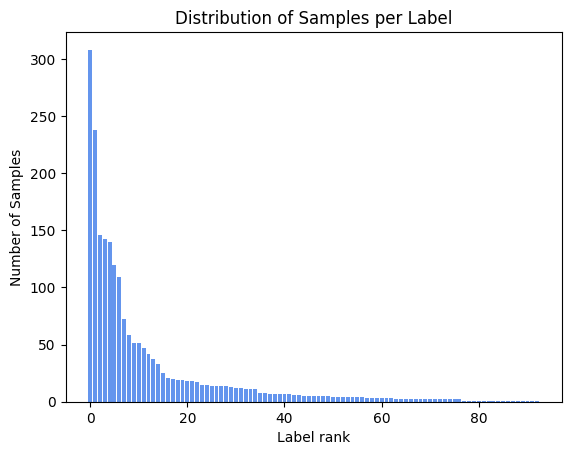

In [40]:
# Show distribution of classes in the sample.
import matplotlib.pyplot as plt

# Number of samples for each label.
samples_count = np.sum(all_labels, axis=0)

sorted_counts = sorted(list(samples_count), reverse=True)

# Generate bar chart
plt.bar(np.arange(len(sorted_counts)), sorted_counts, color='cornflowerblue')
plt.title('Distribution of Samples per Label')
plt.xlabel('Label rank')
plt.ylabel('Number of Samples')
plt.show()